In [229]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Importing data (just original for now)

In [230]:
features_num = [
    'Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST',
       'g_flux_corr', 'nb921_hsc_flux_corr'
    ]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [231]:
data = pd.read_csv("../../Data/MIGHTEE/Classification/final_gaussian_radio_more.csv")

In [232]:
# Dropping nan classifications
data = data[data['Classification'].notna()]

# Dropping quasar-like radio AGN / high-excitation radio galaxy
#mightee_data = mightee_data[mightee_data['Classification'] != 'star-forming galaxy']
print("Amount of rows:", len(data))

Amount of rows: 4370


In [233]:
X = data.drop(columns=['Classification', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN', 'Unnamed: 0', 'S_INT14', 'S_PEAK14'])
y = data[['Classification', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN']]

In [234]:
X.isna().sum(axis=0)

Z_BEST              0
ch1_flux_corr      57
ch2_flux_corr      65
ch3_flux_corr     123
ch4_flux_corr      66
F_MIPS_24           0
F_PACS_100          0
F_PACS_160        437
F_SPIRE_250      1119
F_SPIRE_350      1609
F_SPIRE_500      3100
EBV                 0
Ks_flux_corr       86
H_flux_corr        59
J_flux_corr        47
i_flux_corr        10
r_flux_corr        16
u_flux_corr       158
z_flux_corr         6
y_flux_corr        84
NUV_flux_corr    2217
FUV_flux_corr    3062
Total_flux          0
Peak_flux          94
dtype: int64

# Dropping columns with little data (optional)

In [235]:
X = X.drop(columns=['F_SPIRE_250', 'F_SPIRE_350', 'F_SPIRE_500', 'NUV_flux_corr', 'FUV_flux_corr', 'EBV'])

In [236]:
X.isna().sum(axis=0)/len(X)

Z_BEST           0.000000
ch1_flux_corr    0.013043
ch2_flux_corr    0.014874
ch3_flux_corr    0.028146
ch4_flux_corr    0.015103
F_MIPS_24        0.000000
F_PACS_100       0.000000
F_PACS_160       0.100000
Ks_flux_corr     0.019680
H_flux_corr      0.013501
J_flux_corr      0.010755
i_flux_corr      0.002288
r_flux_corr      0.003661
u_flux_corr      0.036156
z_flux_corr      0.001373
y_flux_corr      0.019222
Total_flux       0.000000
Peak_flux        0.021510
dtype: float64

## Filter by thin redshift slice (optional)

<AxesSubplot:>

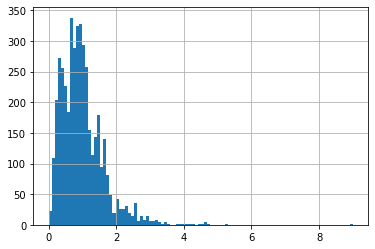

In [237]:
X.Z_BEST.hist(bins=100)

In [238]:
delta_z = 0.3

for z in np.arange(0.1,4,0.1):
    z = round(z,1)
    print(z, sum((X.Z_BEST >z) & (X.Z_BEST <(z+delta_z))))

0.1 722
0.2 818
0.3 830
0.4 797
0.5 884
0.6 1022
0.7 1031
0.8 1040
0.9 936
1.0 700
1.1 538
1.2 490
1.3 468
1.4 469
1.5 354
1.6 288
1.7 168
1.8 120
1.9 94
2.0 105
2.1 83
2.2 79
2.3 78
2.4 65
2.5 60
2.6 30
2.7 37
2.8 31
2.9 31
3.0 25
3.1 17
3.2 15
3.3 9
3.4 7
3.5 2
3.6 2
3.7 4
3.8 5
3.9 4


In [239]:
z = 0.8
#z = 3
delta_z = 0.3

redshift_filt = (X.Z_BEST >z) & (X.Z_BEST <(z+delta_z))
X_sliced = X[redshift_filt]

# Logging the data

In [240]:
# Lots of 0 values in this for some reason, so we just replace them with nans
X_sliced[X_sliced==0] = np.nan

/var/lib/condor/execute/dir_348705/ipykernel_348766/2743811275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_sliced[X_sliced==0] = np.nan
/Software/users/modules/7/software/anaconda3/2021.11/lib/python3.9/site-packages/pandas/core/frame.py:3718: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


In [241]:
X_sliced[[c for c in X_sliced.columns if c!='Z_BEST']] = np.log10(X_sliced.drop(columns='Z_BEST'))

/Software/users/modules/7/software/anaconda3/2021.11/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


# Dropping redshift column (optional)

In [242]:
#X_sliced = X_sliced.drop(columns='Z_BEST')

## Filling nan's

In [243]:
# fill nans with 0s
#X_filled = X.fillna(0)

# FIlling with mean, filling with 0s caused a weird split into 2 groups
#imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
#X_filled = imp_mean.fit_transform(X)

imp = IterativeImputer(max_iter=100, min_value=0)
X_filled = imp.fit_transform(X_sliced)

## Scaling

In [244]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler

scaler = StandardScaler()
X_final = scaler.fit_transform(X_filled)

## Running UMAP

In [245]:
reducer = umap.UMAP(n_neighbors=50, min_dist=0.1)
embedding = reducer.fit_transform(X_final)

In [246]:
embedding.shape

(1040, 2)

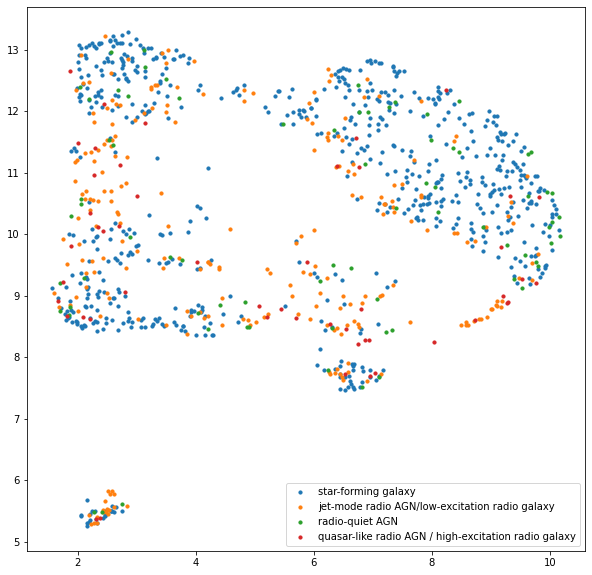

In [247]:
plt.figure(figsize=(10,10))
classes = ['star-forming galaxy',
           'jet-mode radio AGN/low-excitation radio galaxy',
           'radio-quiet AGN',
           'quasar-like radio AGN / high-excitation radio galaxy',
       ]
for i in classes:
    #filt = y.loc[sample.index]['Classification']==i
    filt = y['Classification'][redshift_filt]==i
    #filt = y['Classification']==i
    plt.scatter(embedding[:,0][filt], embedding[:,1][filt], s=10,label=i)
plt.legend()
plt.show()

<AxesSubplot:xlabel='x', ylabel='y'>

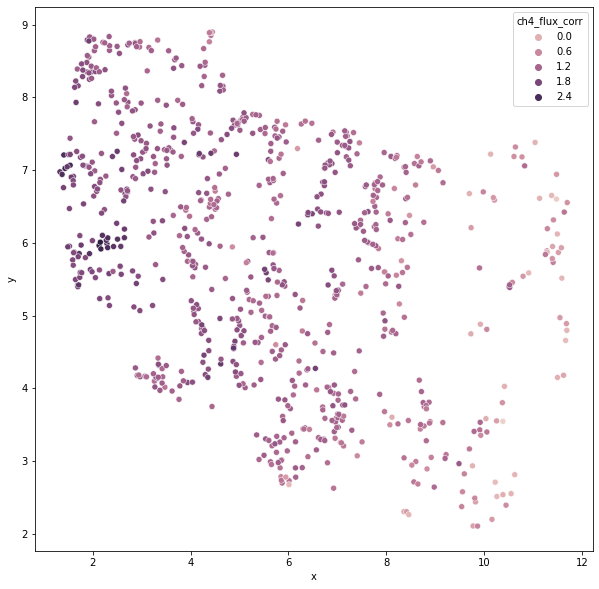

In [204]:
import seaborn as sn
import numpy as np

tempdata = np.hstack((X_filled, embedding, y['Classification'][redshift_filt].to_numpy()[:, np.newaxis]))
columns = list(X.columns)
columns.extend(['x', 'y', 'class'])

temp = pd.DataFrame(data=tempdata, columns=columns)
c = ['ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr',
       'ch4_flux_corr', 'F_MIPS_24', 'F_PACS_100', 'F_PACS_160',
       'Ks_flux_corr', 'H_flux_corr', 'J_flux_corr', 'i_flux_corr',
       'r_flux_corr', 'u_flux_corr', 'z_flux_corr', 'y_flux_corr',
       'Total_flux', 'Peak_flux']
temp[temp==0] = np.nan
temp[c] = np.log10(temp[c].astype(float))

plt.figure(figsize=(10,10))
sn.scatterplot(data=temp, x='x', y='y', hue='ch4_flux_corr')

In [121]:
tempdata = np.hstack((X_filled, embedding, y['Classification'][redshift_filt].to_numpy()[:, np.newaxis]))
columns = list(X.columns)
columns.extend(['x', 'y', 'class'])

temp = pd.DataFrame(data=tempdata, columns=columns)
temp.to_csv('temp.csv', index=False)

## In a loop

Working on number of neighbours 5
Working on number of neighbours 6
Working on number of neighbours 7
Working on number of neighbours 8
Working on number of neighbours 9
Working on number of neighbours 10
Working on number of neighbours 11
Working on number of neighbours 12
Working on number of neighbours 13
Working on number of neighbours 14
Working on number of neighbours 15
Working on number of neighbours 16


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Software/users/modules/7/software/anaconda3/2021.11/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/lib/condor/execute/dir_2195087/ipykernel_2195177/3550598425.py", line 10, in <module>
    X_transformed = reducer.fit_transform(X_final)
  File "/Users/users/karsten/.local/lib/python3.9/site-packages/umap/umap_.py", line 2772, in fit_transform
    self.fit(X, y)
  File "/Users/users/karsten/.local/lib/python3.9/site-packages/umap/umap_.py", line 2684, in fit
    self.embedding_, aux_data = self._fit_embed_data(
  File "/Users/users/karsten/.local/lib/python3.9/site-packages/umap/umap_.py", line 2717, in _fit_embed_data
    return simplicial_set_embedding(
  File "/Users/users/karsten/.local/lib/python3.9/site-packages/umap/umap_.py", line 1156, in simplicial_set_embedding
    embedding = optimize_layout_euclidean(
  File "/Users/users/karst

TypeError: object of type 'NoneType' has no len()

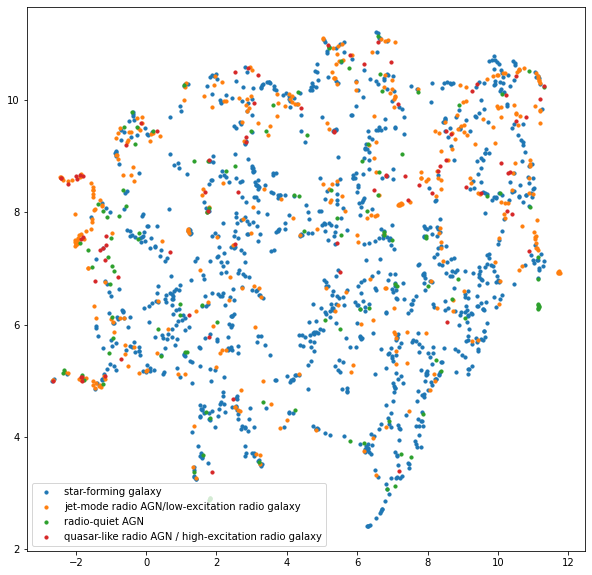

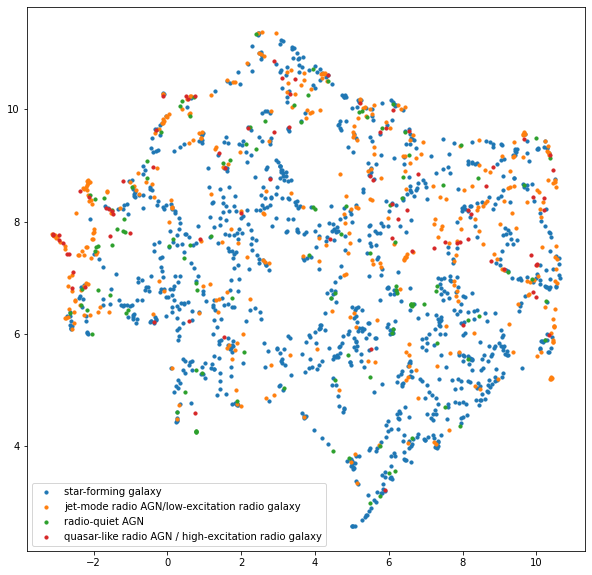

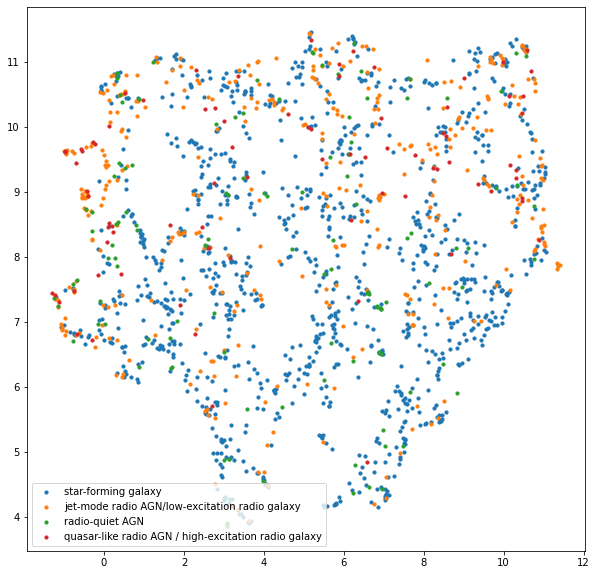

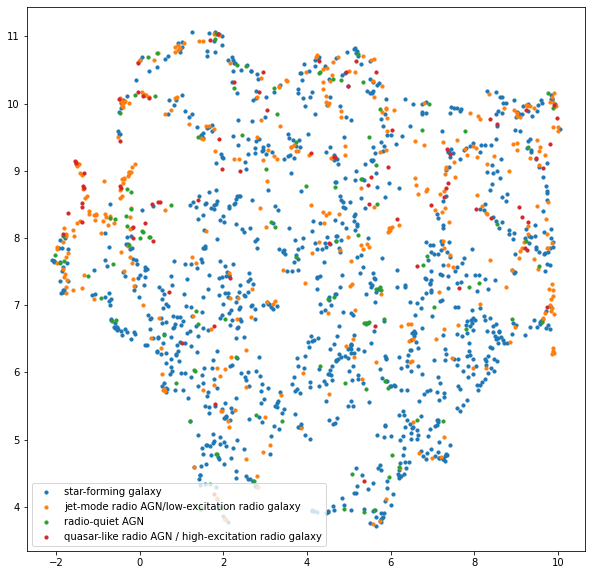

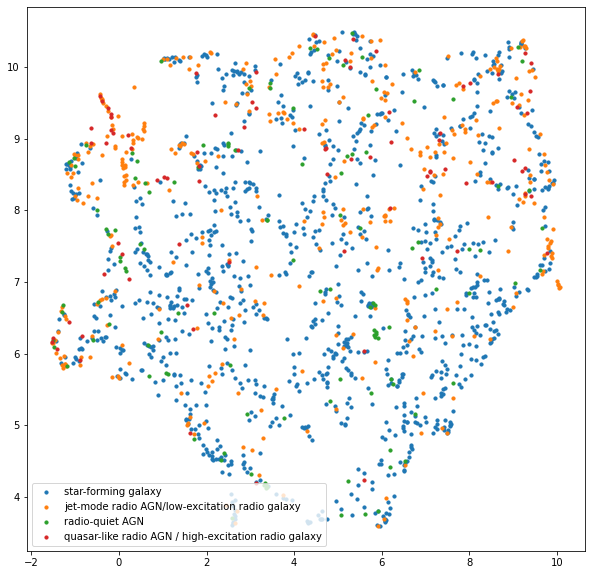

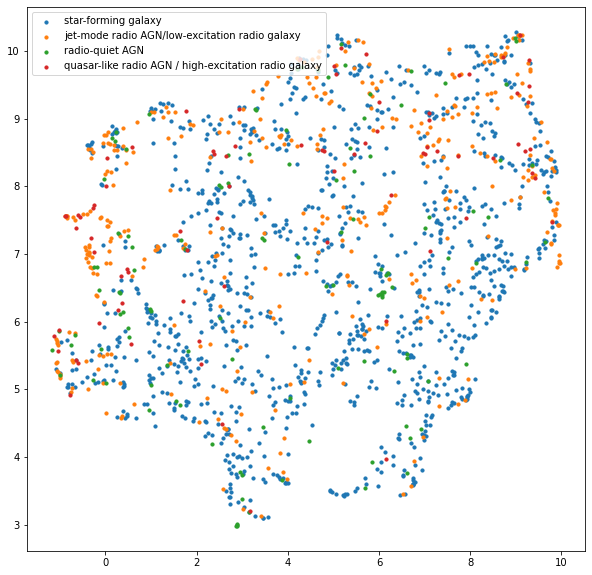

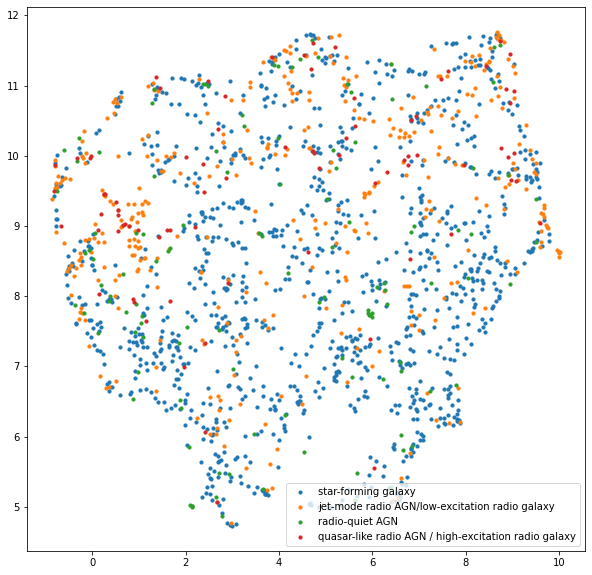

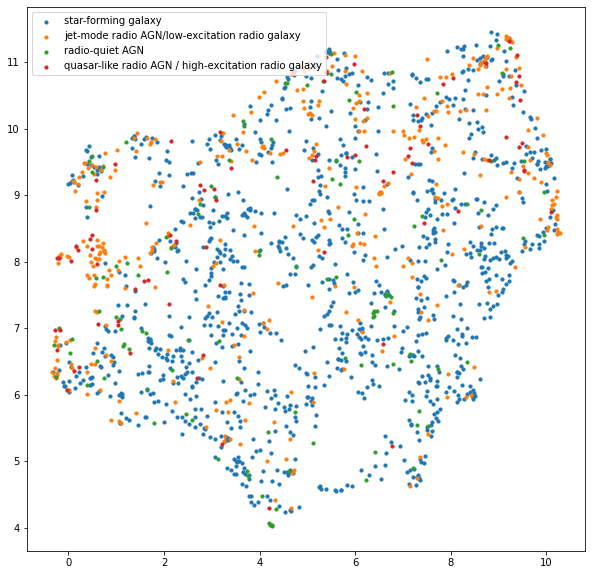

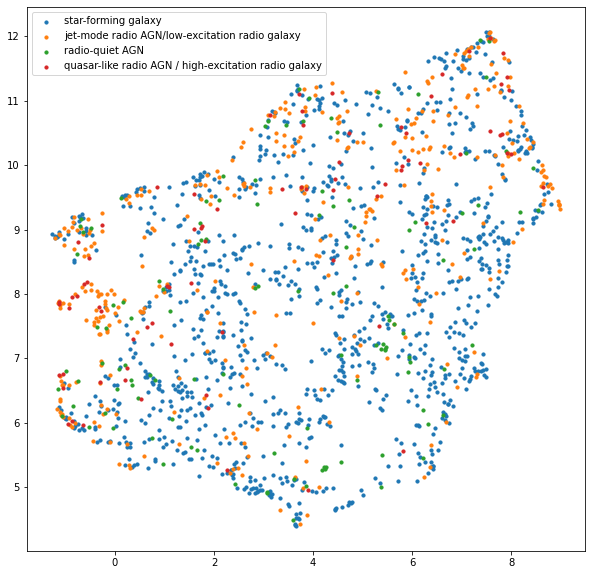

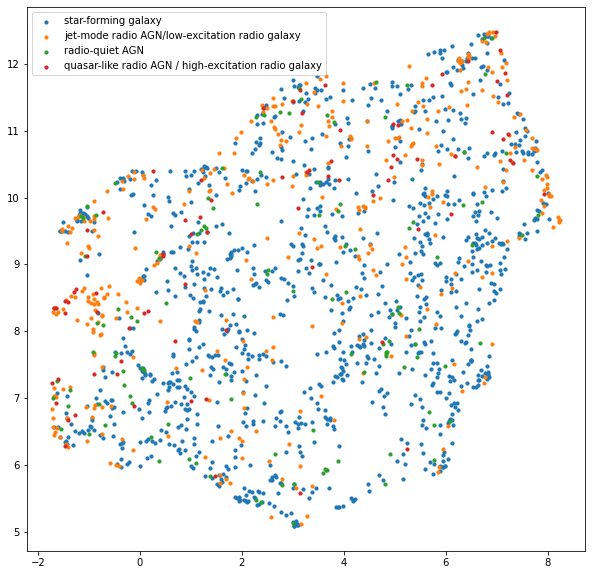

Error in callback <function flush_figures at 0x2ac246e2a1f0> (for post_execute):


KeyboardInterrupt: 

In [19]:
classes = ['star-forming galaxy',
           'jet-mode radio AGN/low-excitation radio galaxy',
           'radio-quiet AGN',
           'quasar-like radio AGN / high-excitation radio galaxy',
       ]
for i in range(5,51,1):
    print(f"Working on number of neighbours {i}")
    
    reducer = umap.UMAP(n_neighbors=i)
    X_transformed = reducer.fit_transform(X_final)

    plt.figure(figsize=(10,10))
    for name in classes:
        filt = y['Classification'][redshift_filt]==name
        plt.scatter(X_transformed[:,0][filt], X_transformed[:,1][filt], s=10, label=name)

    plt.legend()
    plt.savefig(f"./Output/UMAP/{i}.png")
    